# Fix Leakage, Clean Dataset & Train Baseline Model

**Notebook:** `fix_and_model_logistic_regression.ipynb`

**Purpose:** This notebook performs the following in a reproducible, auditable way:

- Load the provided processed dataset (`loan_data_final_output.csv`).
- Detect and fix common target leakage sources (boolean dummies, exact copies, perfect predictors).
- Convert boolean columns to numeric, ensure consistent encoding.
- Remove features that perfectly predict the target or have extremely high correlation (configurable).
- Re-train a Logistic Regression baseline with proper scaling and solver settings.
- Report realistic evaluation metrics and diagnostic plots (ROC curve, confusion matrix).

This notebook is written so reviewers can understand each step and the rationale behind it.


## 0 — Setup & file paths

Edit `INPUT_CSV` if your file has a different name or location. The notebook will write a cleaned CSV to `cleaned_output.csv`.

In [1]:

import pandas as pd, numpy as np, os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

INPUT_CSV = '/content/loan_data_final_output.csv'  # change if needed
CLEANED_CSV = '/content/loan_data_final_proceeding_output.csv'
RANDOM_STATE = 42

print('INPUT:', INPUT_CSV)
print('CLEANED OUTPUT:', CLEANED_CSV)


INPUT: /content/loan_data_final_output.csv
CLEANED OUTPUT: /content/loan_data_final_proceeding_output.csv


## 1 — Load dataset and initial inspection

Rationale: inspect columns, dtypes, and a sample to identify boolean/object columns that may cause leakage.

In [2]:

df = pd.read_csv(INPUT_CSV)
print('Shape:', df.shape)
display(df.head())
print('\nColumn types and non-null counts:')
display(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

Shape: (9578, 25)


,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,...,credit_utilization,annual_inc,debt_to_income_calc,credit_age_years,has_recent_inq,has_past_delinquency,target_default,purpose_debt_consolidation,purpose_educational,purpose_small_business
0,1,0.001189,2.463099,11.350407,0.998505,0.688825,5639.958333,0.353732,0.182704,0,...,0.145575,85000.000385,1.121950,0.432230,0,0,0,True,False,False
1,1,0.001071,-0.438854,11.082143,0.244540,-0.101303,2760.000000,0.495018,1.030602,0,...,1.025163,65000.000073,-0.585293,-0.721230,0,0,0,False,False,False
2,1,0.001357,0.230708,10.373491,-0.141885,-0.759742,4710.000000,-0.397073,-0.730683,1,...,-0.801949,31999.999943,1.589642,0.059770,1,0,0,True,False,False
3,1,0.001008,-0.757022,11.350407,-0.654697,0.030385,2699.958333,0.496321,0.909966,1,...,0.900019,85000.000385,-1.023161,-0.745277,1,0,0,True,False,False
4,1,0.001426,-1.043992,11.299732,0.343326,-1.154806,4066.000000,-0.360663,-0.251586,0,...,-0.304946,80799.999636,-1.197116,-0.198161,0,1,0,False,False,False



Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               9578 non-null   int64  
 1   int_rate                    9578 non-null   float64
 2   installment                 9578 non-null   float64
 3   log_annual_inc              9578 non-null   float64
 4   dti                         9578 non-null   float64
 5   fico                        9578 non-null   float64
 6   days_with_cr_line           9578 non-null   float64
 7   revol_bal                   9578 non-null   float64
 8   revol_util                  9578 non-null   float64
 9   inq_last_6mths              9578 non-null   int64  
 10  delinq_2yrs                 9578 non-null   int64  
 11  pub_rec                     9578 non-null   int64  
 12  not_fully_paid              9578 non-null   int64  
 13

None


Missing values per column:
credit_policy                 0
int_rate                      0
installment                   0
log_annual_inc                0
dti                           0
fico                          0
days_with_cr_line             0
revol_bal                     0
revol_util                    0
inq_last_6mths                0
delinq_2yrs                   0
pub_rec                       0
not_fully_paid                0
repayment_velocity_proxy      0
approx_credit_limit           0
credit_utilization            0
annual_inc                    0
debt_to_income_calc           0
credit_age_years              0
has_recent_inq                0
has_past_delinquency          0
target_default                0
purpose_debt_consolidation    0
purpose_educational           0
purpose_small_business        0
dtype: int64


## 2 — Convert boolean-like columns to numeric

Rationale: Boolean `True/False` columns must be 0/1 integers for safe modeling and consistent correlation checks. We'll convert any column with dtype 'bool' or with only two unique values {True, False} or {'True','False'} to integer 0/1.

In [3]:

bool_cols = []
for c in df.columns:
    # detect actual bool dtype
    if df[c].dtype == bool:
        bool_cols.append(c)
    else:
        # detect string 'True'/'False' or two-value categorical
        u = df[c].dropna().unique()
        if len(u) == 2:
            su = set([str(x).strip().lower() for x in u])
            if su <= {'true','false','0','1','yes','no','y','n'}:
                bool_cols.append(c)

print('Detected boolean-like columns:', bool_cols)

# convert to int
for c in bool_cols:
    df[c] = df[c].map(lambda x: 1 if str(x).strip().lower() in ['true','1','yes','y'] else 0 if pd.notnull(x) else np.nan)

print('\nAfter conversion dtypes:')
display(df[bool_cols].dtypes)
display(df[bool_cols].head())

Detected boolean-like columns: ['credit_policy', 'not_fully_paid', 'has_recent_inq', 'has_past_delinquency', 'target_default', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_small_business']

After conversion dtypes:


,0
credit_policy,int64
not_fully_paid,int64
has_recent_inq,int64
has_past_delinquency,int64
target_default,int64
purpose_debt_consolidation,int64
purpose_educational,int64
purpose_small_business,int64


,credit_policy,not_fully_paid,has_recent_inq,has_past_delinquency,target_default,purpose_debt_consolidation,purpose_educational,purpose_small_business
0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0
2,1,0,1,0,0,1,0,0
3,1,0,1,0,0,1,0,0
4,1,0,0,1,0,0,0,0


## 3 — Target presence & quick checks

Rationale: ensure `target_default` exists and is binary. If not found, stop and ask user to specify target column.

In [4]:

if 'target_default' not in df.columns:
    raise ValueError('target_default column not found. Please ensure the processed dataset contains the binary target.')

print('Target unique values:')
print(df['target_default'].value_counts(dropna=False))

Target unique values:
target_default
0    8045
1    1533
Name: count, dtype: int64


## 4 — Detect perfectly predictive features (exact leakage)

Rationale: features that perfectly separate the target (e.g., all rows with col==1 have target==1 and col==0 have target==0) are leaking. We'll detect columns where mapping to target is deterministic, and drop them after reporting.

In [5]:

perfect_leaks = []
for c in df.columns:
    if c == 'target_default': continue
    # For each unique value in c, check if target is constant
    groups = df.groupby(c)['target_default'].nunique(dropna=False)
    if groups.max() == 1:
        # for this feature, each unique value maps to a single target class -> potential leakage or perfect separator
        perfect_leaks.append(c)

print('Perfectly predictive columns (candidate leaks):', perfect_leaks)
# show example mapping for those columns
for c in perfect_leaks:
    print('\nColumn:', c)
    display(df.groupby(c)['target_default'].agg(['count','mean']))

Perfectly predictive columns (candidate leaks): ['not_fully_paid']

Column: not_fully_paid


,count,mean
not_fully_paid,,
0,8045,0.0
1,1533,1.0


## 5 — Correlation-based leakage detection

Rationale: numeric features perfectly correlated with the target (corr ~ 1.0) are also suspect. We'll compute Pearson correlation for numeric columns and list those with absolute correlation above a threshold (e.g., 0.98).

In [6]:

num = df.select_dtypes(include=[np.number]).copy()
corr_with_target = num.corr()['target_default'].drop('target_default').abs().sort_values(ascending=False)
display(corr_with_target.head(20))

# threshold for strong correlation
THRESH = 0.98
high_corr = corr_with_target[corr_with_target >= THRESH].index.tolist()
print('\nNumerical columns with |corr| >=', THRESH, ':', high_corr)

,target_default
not_fully_paid,1.000000
int_rate,0.159552
credit_policy,0.158119
fico,0.149666
inq_last_6mths,0.149452
has_recent_inq,0.091012
credit_utilization,0.085160
purpose_small_business,0.084460
revol_util,0.082088
debt_to_income_calc,0.074137



Numerical columns with |corr| >= 0.98 : ['not_fully_paid']


## 6 — Decide columns to drop and create cleaned dataset

Rationale: we'll drop all perfectly predictive columns and high-correlation numeric columns. We'll keep a record of dropped columns for auditability.

In [7]:

drop_cols = list(set(perfect_leaks + high_corr))
print('Columns to drop due to leakage/high-correlation:', drop_cols)

# Save a copy before dropping
df_before = df.copy()

# Drop and fill remaining NaNs conservatively (median for numerics, mode for categoricals)
df = df.drop(columns=drop_cols)
print('Shape after drop:', df.shape)

# Impute numeric missing with median, categorical with mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
if num_cols:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else 0)

# Save cleaned dataset
df.to_csv(CLEANED_CSV, index=False)
print('Cleaned dataset saved to:', CLEANED_CSV)
print('\nFinal columns:', df.columns.tolist())

Columns to drop due to leakage/high-correlation: ['not_fully_paid']
Shape after drop: (9578, 24)
Cleaned dataset saved to: /content/loan_data_final_proceeding_output.csv

Final columns: ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'repayment_velocity_proxy', 'approx_credit_limit', 'credit_utilization', 'annual_inc', 'debt_to_income_calc', 'credit_age_years', 'has_recent_inq', 'has_past_delinquency', 'target_default', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_small_business']


## 7 — Feature / Target split and scaling

Rationale: scale numeric features before Logistic Regression to help convergence. We'll use median-imputed numbers and StandardScaler. Categorical non-numeric columns (if any) will be one-hot encoded.

In [8]:

# Split again
X = df.drop(columns=['target_default'])
y = df['target_default'].astype(int)

# One-hot encode remaining object columns
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('Object columns to one-hot:', obj_cols)
if obj_cols:
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)

# Ensure all features are numeric now
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, 'Non-numeric columns remain: ' + str(X.select_dtypes(exclude=[np.number]).columns.tolist())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
print('Train/Test shapes:', X_train.shape, X_test.shape)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Object columns to one-hot: []
Train/Test shapes: (7183, 23) (2395, 23)


## 8 — Train Logistic Regression (robust settings)

Rationale: use solver 'lbfgs' with increased max_iter, or 'saga' for large datasets. We'll set `max_iter=2000` to ensure convergence. We'll also set class_weight='balanced' if the target is skewed.

In [9]:

from sklearn.linear_model import LogisticRegression
# Use class_weight balanced if imbalance detected
from collections import Counter
print('Target distribution:', Counter(y_train))

use_balance = True if (y_train.mean() < 0.3 or y_train.mean() > 0.7) else False
print('Use class_weight=balanced?', use_balance)

model = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced' if use_balance else None)
model.fit(X_train, y_train)
print('Training complete.')

Target distribution: Counter({0: 6033, 1: 1150})
Use class_weight=balanced? True
Training complete.


## 9 — Evaluation & Diagnostics

Rationale: report accuracy, precision, recall, F1, AUC-ROC, confusion matrix and ROC curve. Inspect metrics to ensure model behaves realistically.

Accuracy: 0.6459
Precision: 0.2408
Recall: 0.5640
F1 Score: 0.3375
AUC-ROC: 0.6767


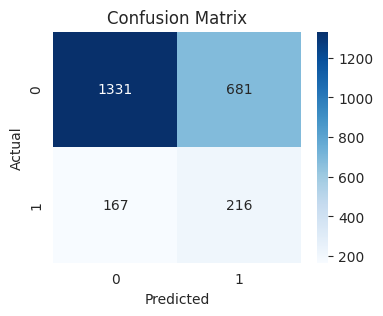

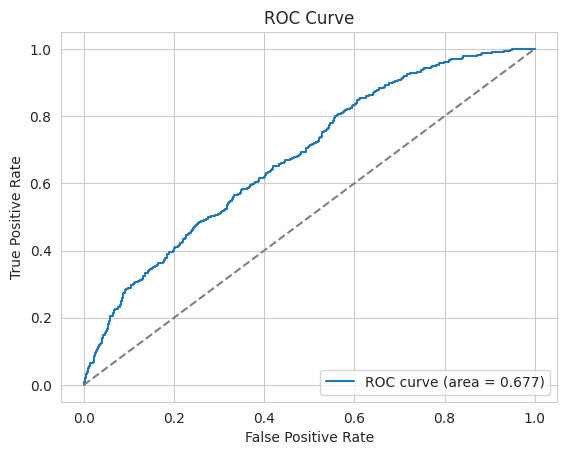

In [10]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_score = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {auc_score:.4f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
ax.plot([0,1],[0,1],'--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
plt.show()


## 10 — Feature importance (coefficients)

Rationale: inspect coefficients to see which features push the prediction towards default. For scaled features, coefficient magnitude indicates importance.

In [11]:

# Map coefficients back to feature names
coef = model.coef_[0]
feature_names = X.columns if isinstance(X, pd.DataFrame) else None
if feature_names is None:
    # X was transformed to array; reload feature names by reconstructing dummies
    X_df = pd.read_csv(CLEANED_CSV).drop(columns=['target_default'])
    X_df = pd.get_dummies(X_df, drop_first=True)
    feature_names = X_df.columns.tolist()

coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
display(coef_df.head(20))

,feature,coef,abs_coef
0,fico,-0.272707,0.272707
1,log_annual_inc,-0.233439,0.233439
2,inq_last_6mths,0.223511,0.223511
3,purpose_small_business,0.174195,0.174195
4,debt_to_income_calc,0.131808,0.131808
5,credit_policy,-0.128926,0.128926
6,annual_inc,0.120187,0.120187
7,int_rate,0.108882,0.108882
8,installment,0.092870,0.092870
9,revol_util,0.090900,0.090900


## Appendix: Audit log of dropped columns

Rationale: keep an auditable record of columns dropped due to leakage or high correlation. You can store this in project docs.

In [12]:

# Save list of dropped columns
dropped_info = {'dropped_columns': drop_cols}
with open('/content/dropped_columns.json', 'w') as f:
    import json
    json.dump(dropped_info, f)
print('Dropped columns saved to /content/dropped_columns.json')

Dropped columns saved to /content/dropped_columns.json
